<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [82]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet, ElasticNetCV, LassoCV, LogisticRegression
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [83]:
# Load the data
df = pd.read_csv('./housing.csv')

In [84]:
# allows me to use the index to compare between slices
df.set_index('Id', inplace=True)

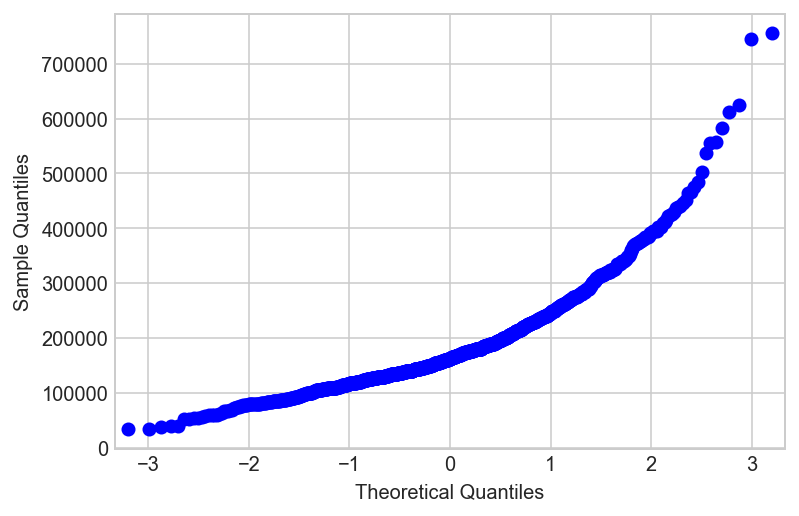

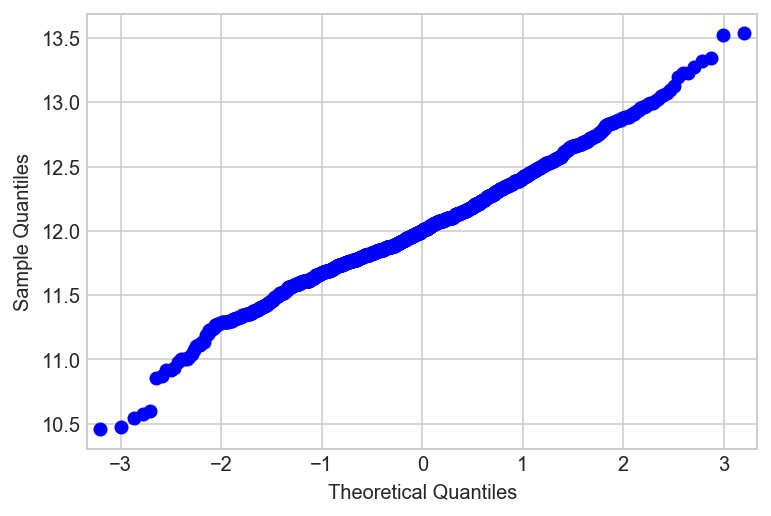

In [85]:
# some values fit a normal distribution better when log is applied

qqplot(df.SalePrice)
qqplot(df.SalePrice.apply(np.log))
plt.figure()

In [86]:
# using stats.normaltest to check for normality when applying different transformations
print(stats.normaltest(df.SalePrice.apply(lambda x: x)))
print(stats.normaltest(df.SalePrice.apply(np.log)))
print(stats.normaltest(df.SalePrice.apply(lambda x: x**0.5)))

NormaltestResult(statistic=610.8359109472653, pvalue=2.283848353787728e-133)
NormaltestResult(statistic=25.507009834238303, pvalue=2.89216582205235e-06)
NormaltestResult(statistic=228.80624119955436, pvalue=2.0670739363113531e-50)


In [87]:
# iterates through the dataframe for all columns that are not objects, and applies
# the transformation method that brings it closest to a normal distribution

# methods are no change, log and square root
methods = [lambda x: x, np.log, lambda x: x**0.5]

for column in [i for i, dtype in zip(df.dtypes.index, df.dtypes) if dtype != 'object']:
    df[column] = df[column].apply((min([(stats.normaltest(df[column].apply(a)), a) for a in methods], key = lambda t: t[0])[1]))    

In [88]:
description = open('data_description.txt')
for row in description:
    print(row)

MSSubClass: Identifies the type of dwelling involved in the sale.	



        20	1-STORY 1946 & NEWER ALL STYLES

        30	1-STORY 1945 & OLDER

        40	1-STORY W/FINISHED ATTIC ALL AGES

        45	1-1/2 STORY - UNFINISHED ALL AGES

        50	1-1/2 STORY FINISHED ALL AGES

        60	2-STORY 1946 & NEWER

        70	2-STORY 1945 & OLDER

        75	2-1/2 STORY ALL AGES

        80	SPLIT OR MULTI-LEVEL

        85	SPLIT FOYER

        90	DUPLEX - ALL STYLES AND AGES

       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER

       150	1-1/2 STORY PUD - ALL AGES

       160	2-STORY PUD - 1946 & NEWER

       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER

       190	2 FAMILY CONVERSION - ALL STYLES AND AGES



MSZoning: Identifies the general zoning classification of the sale.

		

       A	Agriculture

       C	Commercial

       FV	Floating Village Residential

       I	Industrial

       RH	Residential High Density

       RL	Residential Low Density

       RP	Residential 

In [89]:
# features that are removed for being renovatable
renovatable = ['OverallQual','OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType',
               'MasVnrArea','ExterQual','ExterCond','BsmtCond','BsmtFinType1','BsmtFinType2','BsmtUnfSF','BsmtFinSF2',
               'BsmtFinSF1','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
               'GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','LowQualFinSF']

In [90]:
# df.columns

In [91]:
df.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [92]:
# dropping all non-residential
df.drop(df[df.MSZoning == 'C (all)'].index, inplace = True)

In [93]:
df.drop(renovatable, axis = 1, inplace = True)

In [94]:
# df.columns

In [95]:
# df.dtypes

In [96]:
# returns the unique objects and their counts for all columns of datatype 'object'
for i, column in zip(df.dtypes.index, df.dtypes):
    if column == 'object':
        print(df[i].value_counts())

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64
Pave    1446
Grvl       4
Name: Street, dtype: int64
Grvl    50
Pave    39
Name: Alley, dtype: int64
Reg    916
IR1    483
IR2     41
IR3     10
Name: LotShape, dtype: int64
Lvl    1305
Bnk      62
HLS      49
Low      34
Name: LandContour, dtype: int64
AllPub    1449
NoSeWa       1
Name: Utilities, dtype: int64
Inside     1044
Corner      261
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
Gtl    1375
Mod      62
Sev      13
Name: LandSlope, dtype: int64
NAmes      225
CollgCr    150
OldTown    112
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      28
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64
Norm      1252
Feedr       79

In [97]:
# removing those with categories that are either too few or not significantly distributed
df.drop(['GarageType','Condition2','Condition1','Utilities','Street'], axis = 1, inplace = True)

In [98]:
# function that allows me to set a cutoff below which all remaining
# (insignificant) features will be grouped into the same category
def dummy(column, cutoff):
    for cat in [i for i, col in zip(df[column].value_counts().index,df[column].value_counts()) if col > cutoff]:
        df[column+cat] = [1 if value == cat else 0 for value in df[column]]
    df.drop(column, axis = 1, inplace=True)

In [99]:
# df.columns

In [100]:
# one last drop for columns that are not directl related to the house or likely to have an effect on price
df.drop(['MoSold', 'SaleType', 'SaleCondition'], axis = 1, inplace = True)

In [101]:
dummy('MSZoning', 30)
dummy('Alley', 30)
dummy('LotShape', 40)
dummy('LandContour', 30)
dummy('LotConfig', 40)
dummy('MiscFeature', 40)
dummy('LandSlope', 50)
dummy('BsmtExposure', 100)
dummy('Neighborhood', 35)
dummy('BsmtQual', 30)
dummy('Foundation', 100)
dummy('BldgType', 40)
dummy('HouseStyle', 30)

In [102]:
df.dropna(inplace = True)

In [103]:
# splitting into train/test by year sold

df_test = df[df.YrSold >= 2010].copy()
df_test.drop('YrSold', axis = 1, inplace = True)
df_train = df[df.YrSold < 2010].copy()
df_train.drop('YrSold', axis = 1, inplace = True)

In [104]:
# df_test.columns

In [105]:
y_test = df_test.SalePrice
X_test = df_test[[column for column in df_test.columns if column != 'SalePrice']]
y_train = df_train.SalePrice
X_train = df_train[[column for column in df_train.columns if column != 'SalePrice']]

In [106]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
# can just use normalize = True?

In [107]:
multiplier = np.array([i/100 for i in range(80,121,10)])
multiplier

array([0.8, 0.9, 1. , 1.1, 1.2])

In [108]:
# takes the best alpha and runs 10 iterations narrowing down the alpha each time
alpha = (0.1, 1.0, 100.0)
for i in range(10):
    ridge = RidgeCV(alphas=alpha)
    ridge.fit(X_train_scaled, y_train)
    alpha = (ridge.alpha_*multiplier)

In [109]:
lass = LassoCV()
lass.fit(X_train_scaled, y_train)
#np.mean(cross_val_score(lass, X_train_scaled, y_train, cv = 10))

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [110]:
elas = ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1],selection='random')
elas.fit(X_train_scaled, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
       n_alphas=100, n_jobs=1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='random',
       tol=0.0001, verbose=0)

In [111]:
slr = LinearRegression()
slr.fit(X_train, y_train)
# ridge = Ridge(alpha = 292)
# lass = LassoCV()
# elas = ElasticNet(alpha = 0.012436275503853832)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [112]:
# ridge.fit(X_train_scaled, y_train)
# lass.fit(X_train_scaled, y_train)
# elas.fit(X_train_scaled, y_train)
print('SLR mean Score = ', np.mean(cross_val_score(slr, X_train, y_train, cv = 10)))
print('Ridge mean Score = ', np.mean(cross_val_score(ridge, X_train_scaled, y_train, cv = 10)))
print('Lasso mean Score = ', np.mean(cross_val_score(lass, X_train_scaled, y_train, cv = 10)))
print('ElasticNet mean Score = ', np.mean(cross_val_score(elas, X_train_scaled, y_train, cv = 10)))

print('SLR R-squared =',slr.score(X_test, y_test))
print('Ridge R-squared =',ridge.score(X_test_scaled, y_test))
print('Lasso R-squared =',lass.score(X_test_scaled, y_test))
print('ElasticNet R-squared =',elas.score(X_test_scaled, y_test))

SLR mean Score =  0.8384989802985157
Ridge mean Score =  0.8532355347392457
Lasso mean Score =  0.8530408542421888
ElasticNet mean Score =  0.8529315673425554
SLR R-squared = 0.9153899750902864
Ridge R-squared = 0.9148372689111983
Lasso R-squared = 0.9202438406123076
ElasticNet R-squared = 0.9188405925916833


In [113]:
# Ridge has the highest mean score as seen from the cross validation test
y_pred = ridge.predict(X_test_scaled)
df_test['y_pred'] = y_pred
df_test['Residuals'] = df_test['y_pred'].apply(lambda x: np.e**x) - df_test['SalePrice'].apply(lambda x: np.e**x)
df_test.Residuals.apply(abs).mean()

15370.54178494135

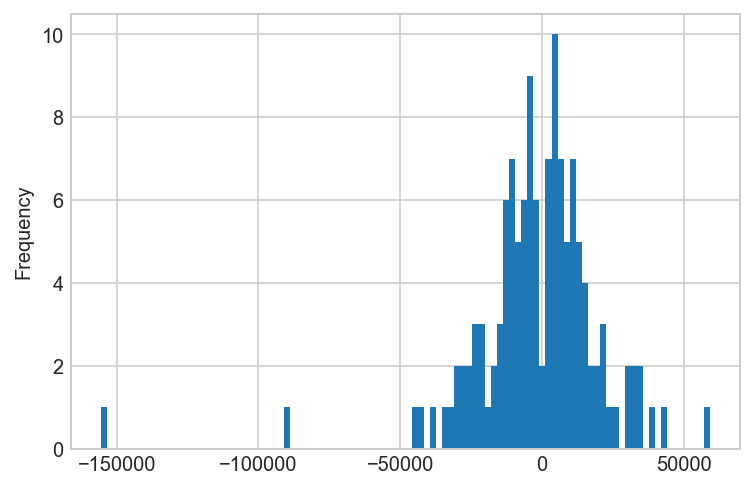

In [114]:
df_test.Residuals.plot(kind='hist', bins=100)

The model that scored highest on the training set cross validation test, Ridge, which is hence the least likely to overfit, is able to account for 91% of the variance in the test set. This means that the majority of the variance in sale price can be accounted for by the non-renovatable features alone, which doesn't bode well for the second question.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [115]:
# checking difference in columns so that I can apply the earlier model to the whole dataset instead of just test or train
for i in df.columns:
    if i not in X_test.columns:
        print(i)

YrSold
SalePrice


In [116]:
# A:
df2 = pd.read_csv('./housing.csv')
df2.set_index('Id', inplace=True)

df_renovatable = df2.loc[df.index][renovatable].copy()
y_pred = ridge.predict(scaler.fit_transform(df.drop(['SalePrice', 'YrSold'], axis=1)))
residual = np.e**y_pred - np.e**df.SalePrice
df_renovatable['residual'] = residual

np.mean(abs(residual))

17768.117069857282

In [117]:
# should I drop these outliers?

df_renovatable[df_renovatable['residual'] < -200000]

,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,...,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,LowQualFinSF,residual
Id,,,,,,,,,,,,,,,,,,,,,
692,10,6,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,...,Typ,Ex,Fin,TA,TA,Y,NaN,NaN,0,-216647.506713
1183,10,5,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,...,Typ,TA,Fin,TA,TA,Y,Ex,MnPrv,0,-281840.578646


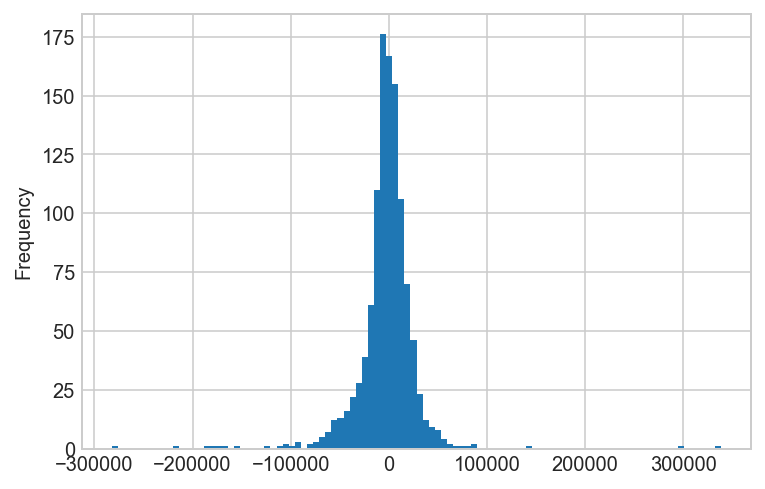

In [118]:
df_renovatable.residual.plot(kind='hist',bins=100)

In [119]:
# transforming it to become positive so that it can accept a log function
df_renovatable['residual'] = df_renovatable.residual.apply(lambda x: x - min(df_renovatable.residual))

In [120]:
df_renovatable.residual.describe()

count      1119.000000
mean     279281.248628
std       31081.645716
min           0.000000
25%      270463.884713
50%      280904.139433
75%      291830.248230
max      620437.112871
Name: residual, dtype: float64

In [121]:
df_renovatable.dtypes

OverallQual       int64
OverallCond       int64
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
MasVnrArea      float64
ExterQual        object
ExterCond        object
BsmtCond         object
BsmtFinType1     object
BsmtFinType2     object
BsmtUnfSF         int64
BsmtFinSF2        int64
BsmtFinSF1        int64
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
PoolQC           object
Fence            object
LowQualFinSF      int64
residual        float64
dtype: object

In [122]:
# iterates through the dataframe for all columns that are not objects, and applies
# the transformation method that brings it closest to a normal distribution

methods = [lambda x: x, np.log, lambda x: x**0.5]

for column in [i for i, dtype in zip(df_renovatable.dtypes.index, df_renovatable.dtypes) if dtype != 'object']:
    df_renovatable[column] = df_renovatable[column].apply((min([(stats.normaltest(df_renovatable[column].apply(a)), a) for a in methods], key = lambda t: t[0])[1]))    

In [123]:
for i, j in zip(df_renovatable.dtypes.index, df_renovatable.dtypes):
    if j == 'object':
        print(df_renovatable[i].value_counts())

Gable      866
Hip        232
Gambrel      9
Flat         6
Mansard      6
Name: RoofStyle, dtype: int64
CompShg    1102
WdShngl       6
Tar&Grv       6
WdShake       2
Membran       1
ClyTile       1
Roll          1
Name: RoofMatl, dtype: int64
VinylSd    431
MetalSd    170
HdBoard    155
Wd Sdng    150
Plywood     68
CemntBd     47
BrkFace     39
WdShing     22
Stucco      19
AsbShng     13
BrkComm      2
Stone        1
ImStucc      1
CBlock       1
Name: Exterior1st, dtype: int64
VinylSd    422
MetalSd    167
Wd Sdng    147
HdBoard    142
Plywood     87
CmentBd     47
Wd Shng     29
BrkFace     20
Stucco      20
AsbShng     14
ImStucc      9
Brk Cmn      7
Stone        4
AsphShn      2
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64
None       652
BrkFace    333
Stone      119
BrkCmn       9
Name: MasVnrType, dtype: int64
TA    664
Gd    403
Ex     47
Fa      5
Name: ExterQual, dtype: int64
TA    998
Gd    103
Fa     16
Ex      2
Name: ExterCond, dtype: int64
TA    100

In [124]:
df_renovatable.drop(['RoofMatl','BsmtCond','Heating','CentralAir','Electrical','Functional','GarageCond','GarageQual','PavedDrive','PoolQC','Fence'], axis=1, inplace=True)

In [125]:
def dummy(column, cutoff):
    for cat in [i for i, col in zip(df_renovatable[column].value_counts().index,df_renovatable[column].value_counts()) if col > cutoff]:
        df_renovatable[column+cat] = [1 if value == cat else 0 for value in df_renovatable[column]]
    df_renovatable.drop(column, axis = 1, inplace=True)

In [126]:
dummy('RoofStyle',10)
dummy('GarageFinish',10)
dummy('FireplaceQu',30)
dummy('KitchenQual',30)
dummy('HeatingQC',31)
dummy('BsmtFinType2',30)
dummy('BsmtFinType1',100)
dummy('ExterCond',20)
dummy('ExterQual',10)
dummy('MasVnrType',10)
dummy('Exterior2nd',30)
dummy('Exterior1st',70)

In [127]:
df_renovatable.dropna(inplace=True)

In [128]:
X_train, X_test, y_train, y_test = train_test_split(df_renovatable.drop('residual',axis=1), df_renovatable.residual, test_size=0.2, random_state = 1)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [129]:
# takes the best alpha and runs 10 iterations narrowing down the alpha each time
alpha = (0.1, 1.0, 100.0)
for i in range(10):
    ridge = RidgeCV(alphas=alpha)
    ridge.fit(X_train_scaled, y_train)
    alpha = (ridge.alpha_*multiplier)

In [130]:
lass = LassoCV()
lass.fit(X_train_scaled, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [131]:
elas = ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1],selection='random')
elas.fit(X_train_scaled, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=1000,
       n_alphas=100, n_jobs=1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='random',
       tol=0.0001, verbose=0)

In [132]:
slr = LinearRegression()
slr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [133]:
print('SLR mean Score = ', np.mean(cross_val_score(slr, X_train, y_train, cv=10)))
print('Ridge mean Score = ', np.mean(cross_val_score(ridge, X_train_scaled, y_train, cv=10)))
print('Lasso mean Score = ', np.mean(cross_val_score(Lasso(), X_train_scaled, y_train, cv=10)))
print('ElasticNet mean Score = ', np.mean(cross_val_score(ElasticNet(), X_train_scaled, y_train, cv=10)))

print('SLR R-squared =',slr.score(X_test, y_test))
print('Ridge R-squared =',ridge.score(X_test_scaled,y_test))
print('Lasso R-squared =',lass.score(X_test_scaled,y_test))
print('ElasticNet R-squared =',elas.score(X_test_scaled,y_test))

SLR mean Score =  0.03901631749988227
Ridge mean Score =  0.09008368292324895
Lasso mean Score =  0.039452547181837515
ElasticNet mean Score =  0.09219152773799218
SLR R-squared = 0.1701264737582573
Ridge R-squared = 0.1392335877522024
Lasso R-squared = 0.18049372333359126
ElasticNet R-squared = 0.18047721835777997


This result does not bode well for the company, as the first model is predicting the price so well that the remaining residuals can be thought of as mostly just random variance, which the renovatable features are unable to predict successfully. ElasticNet, the highest scoring model in the cross validation test with an average R-squared of only 0.09, performed only slightly better on the test set.

In [134]:
col_coef = [_ for _ in zip(X_test.columns, elas.coef_)]

In [135]:
sorted(col_coef, reverse=True, key = lambda x: abs(x[1]))[:4]

[('OverallQual', -5084.862891142821),
 ('KitchenQualEx', -4393.07692340428),
 ('OverallCond', -3407.9523150839723),
 ('BsmtFinType1Unf', 1229.1212087308838)]

Of the coefficients that scored highly on the highest performing model, Overall Quality, Kitchen Quality and Overall Condition, which are self-explanatory, have the highest impact on prices, followed by whether or not the basement is unfinished.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [178]:
# A:
df3 = pd.read_csv('./housing.csv')
df3['abnormal'] = [1 if _ == 'Abnorml' else 0 for _ in df3.SaleCondition]

In [179]:
df3.abnormal.sum()

101

**Start with trying Logistic Regression normally**

In [180]:
df3.corr()['abnormal']

Id               0.007009
MSSubClass       0.005003
LotFrontage     -0.023965
LotArea         -0.029126
OverallQual     -0.103535
OverallCond     -0.046367
YearBuilt       -0.110233
YearRemodAdd    -0.135942
MasVnrArea      -0.044767
BsmtFinSF1      -0.024832
BsmtFinSF2       0.048347
BsmtUnfSF       -0.023821
TotalBsmtSF     -0.032031
1stFlrSF        -0.030196
2ndFlrSF        -0.030743
LowQualFinSF     0.071119
GrLivArea       -0.041173
BsmtFullBath    -0.020603
BsmtHalfBath     0.036065
FullBath        -0.093473
HalfBath        -0.057292
BedroomAbvGr    -0.014928
KitchenAbvGr     0.015880
TotRmsAbvGrd    -0.050332
Fireplaces      -0.087597
GarageYrBlt     -0.109495
GarageCars      -0.110124
GarageArea      -0.096837
WoodDeckSF      -0.049907
OpenPorchSF     -0.010135
EnclosedPorch    0.082110
3SsnPorch        0.004755
ScreenPorch      0.024690
PoolArea         0.052981
MiscVal         -0.018354
MoSold           0.014467
YrSold          -0.031291
SalePrice       -0.118069
abnormal    

In [181]:
# iterates through the dataframe for all columns that are not objects, and applies
# the transformation method that brings it closest to a normal distribution

# not necessary for logistic regression?

methods = [lambda x: x, np.log, lambda x: x**0.5]
for column in [i for i, dtype in zip(df3.dtypes.index, df3.dtypes) if dtype != 'object']:
    df3[column] = df3[column].apply((min([(stats.normaltest(df3[column].apply(a)), a) for a in methods], key = lambda t: t[0])[1]))    

In [182]:
def dummy(column, cutoff):
    for cat in [i for i, col in zip(df3[column].value_counts().index,df3[column].value_counts()) if col > cutoff]:
        df3[column+cat] = [1 if value == cat else 0 for value in df3[column]]
    df3.drop(column, axis = 1, inplace=True)

In [183]:
dummy('MSZoning', 30)
dummy('Alley', 30)
dummy('LotShape', 40)
dummy('LandContour', 30)
dummy('LotConfig', 40)
dummy('MiscFeature', 40)
dummy('LandSlope', 50)
dummy('BsmtExposure', 100)
dummy('Neighborhood', 35)
dummy('BsmtQual', 30)
dummy('Foundation', 100)
dummy('BldgType', 40)
dummy('HouseStyle', 30)
dummy('RoofStyle',10)
dummy('GarageFinish',10)
dummy('FireplaceQu',30)
dummy('KitchenQual',30)
dummy('HeatingQC',31)
dummy('BsmtFinType2',30)
dummy('BsmtFinType1',100)
dummy('ExterCond',20)
dummy('ExterQual',10)
dummy('MasVnrType',10)
dummy('Exterior2nd',30)
dummy('Exterior1st',70)

In [184]:
df3.drop(['GarageType','Condition2','Condition1','Utilities','Street'], axis = 1, inplace = True)
df3.drop(['RoofMatl','BsmtCond','Heating','CentralAir','Electrical','Functional','GarageCond','GarageQual','PavedDrive','PoolQC','Fence'], axis=1, inplace=True)
df3.drop(['SaleType', 'SaleCondition', 'Id'], axis = 1, inplace = True)

In [185]:
for o, i in zip(df3.dtypes.index, df3.dtypes):
    if i == 'object':
        print(o)

In [186]:
df3.dropna(inplace=True)

In [187]:
X_train, X_test, y_train, y_test = train_test_split(df3.drop('abnormal',axis=1), df3.abnormal, test_size=0.2, random_state = 1)

In [257]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
print(logreg.score(X_test, y_test))

0.8977777777777778


In [258]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,logreg.predict(X_test))

array([[202,   1],
       [ 22,   0]], dtype=int64)

The score looks deceivingly good, but the confusion matrix reveals that the model fails to predict all the abnormal cases in the test set, and is merely scoring well for non-abnormality.

In [268]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
confusion_matrix(y_test,clf.predict(X_test))

0.8711111111111111


array([[193,  10],
       [ 19,   3]], dtype=int64)

This is slightly better - although the overall accuracy has decreased, the model is actually able to predict in some cases when the sale is abnormal.

In [243]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

confusion_matrix(y_test,rfc.predict(X_test))

array([[203,   0],
       [ 22,   0]], dtype=int64)

Doesn't work.

In [200]:
df3 = pd.concat([X_train, y_train], axis=1)

In [201]:
df3.shape

(896, 143)

In [202]:
# subtracting abnormal from the shape will give 
# me the total number of non-abnormal rows, which lets me upsample to a 50:50 ratio
df3.abnormal.sum()

49

**Resampling to increase the number of abnormal values in the training set without touching the testing set**

In [203]:
from sklearn.utils import resample

resample(df3[df3.abnormal == 1],n_samples=847).head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Exterior2ndWd Sdng,Exterior2ndPlywood,Exterior2ndCmentBd,Exterior2ndWd Shng,Exterior1stVinylSd,Exterior1stHdBoard,Exterior1stMetalSd,Exterior1stWd Sdng,Exterior1stPlywood,abnormal
1413,4.472136,88.0,9.305105,8,2.236068,44.777226,7.603898,366.0,976,0.0,...,0,0,0,0,1,0,0,0,0,1
410,4.472136,68.0,9.166493,5,1.732051,44.249294,7.579679,0.0,0,0.0,...,0,0,0,0,0,0,0,0,0,1
38,4.472136,68.0,8.977399,5,2.645751,44.192760,7.604396,0.0,731,0.0,...,0,0,0,0,1,0,0,0,0,1
91,4.472136,85.0,9.047821,5,1.732051,44.283180,7.581210,203.0,600,0.0,...,0,0,0,0,0,1,0,0,0,1
19,4.472136,70.0,8.930626,5,2.449490,44.249294,7.583248,0.0,504,0.0,...,0,1,0,0,0,0,0,0,0,1


In [204]:
df3 = pd.concat([df3[df3.abnormal == 0], resample(df3[df3.abnormal == 1],n_samples=847)])

In [205]:
df3.shape

(1694, 143)

In [206]:
X1_train, X1_test, y1_train, y1_test = train_test_split(df3.drop('abnormal',axis=1), df3.abnormal, test_size=0.2, random_state=1)

In [207]:
logreg = LogisticRegression()
logreg.fit(X1_train,y1_train)
print(logreg.score(X1_test,y1_test))
confusion_matrix(y1_test,logreg.predict(X1_test))

0.8672566371681416


array([[139,  38],
       [  7, 155]], dtype=int64)

In [209]:
logreg_predict = confusion_matrix(y_test,logreg.predict(X_test))
print('Percentage of correct abnormal guesses: {}'.format(logreg_predict[1][1]/(logreg_predict[0][1] + logreg_predict[1][1])))
logreg_predict

Percentage of correct abnormal guesses: 0.15


array([[169,  34],
       [ 16,   6]], dtype=int64)

Logistic Regression is able to predict more of the abnormal cases, although it has sacrificed accuracy and gotten a lot of false negatives

In [237]:
clf = tree.DecisionTreeClassifier()
clf.fit(X1_train, y1_train)
print(clf.score(X1_test, y1_test))
confusion_matrix(y1_test,clf.predict(X1_test))

0.9351032448377581


array([[155,  22],
       [  0, 162]], dtype=int64)

In [241]:
confu_predict = confusion_matrix(y_test,clf.predict(X_test))
print('Percentage of correct abnormal guesses: {}'.format(confu_predict[1][1]/(confu_predict[0][1] + confu_predict[1][1])))
confu_predict

Percentage of correct abnormal guesses: 0.09523809523809523


array([[184,  19],
       [ 20,   2]], dtype=int64)

The tree model performs slightly worse than before resampling, but not by much.

In [212]:
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X1_train, y1_train)
print(rfc.score(X1_test, y1_test))
confusion_matrix(y1_test,rfc.predict(X1_test))

1.0


array([[177,   0],
       [  0, 162]], dtype=int64)

In [213]:
confusion_matrix(y_test,rfc.predict(X_test))

array([[203,   0],
       [ 22,   0]], dtype=int64)

The random forest model classifies everything as non-abnormal, same as before resampling.

The best model obtained was the logistic regression model, which managed to get 15% of its guesses for abnormality correct. Even then it was unable to predict 73% of the abnormal sales from the test data used.

In [256]:
sorted([_ for _ in zip(X1_train.columns, logreg.coef_[0])], key = lambda x: abs(x[1]), reverse = True)[:5]

[('SalePrice', -1.9940959442465849),
 ('HouseStyleSLvl', 1.3427810610477622),
 ('MSZoningRM', -1.0740030009572599),
 ('BsmtExposureGd', -0.9752900467236271),
 ('OverallCond', -0.9331658490904471)]

The top 5 predictors of abnormality are sale prices, the presence of a split level, whether or not the residential zone is of a medium density, whether or not the basement is well exposed as well as the overall condition of the house.